In [1]:
!pip install neptune-notebooks > /dev/null # no output
!pip install neptune-client > /dev/null # no output

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
!conda install gdcm -c conda-forge -y

In [3]:
class CFG:
    debug=False
    image_size=256
    lr=5e-3
    batch_size=16
    epochs=25
    seed=42
    N = 36
    n_fold=3

resume=False
fp16=False
accumulation_steps=10
accumulate=False
num_workers=2
quantiles = (0.2, 0.5, 0.8)
HM_SLICES = 40

In [4]:
%matplotlib inline

import numpy as np
import pandas as pd
import pydicom
import math
import matplotlib.pyplot as plt
import cv2
import gc
import random
import time
import os
from time import perf_counter
from tqdm import tqdm
from multiprocessing import Pool
from contextlib import contextmanager
from pathlib import Path
from collections import defaultdict, Counter
from IPython.core.display import display, HTML

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import figure_factory as FF
from plotly.graph_objs import *

from skimage import data
from skimage import measure, feature, morphology
from skimage.util import montage
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing, binary_dilation, binary_opening
from skimage.measure import label,regionprops, perimeter
from skimage.filters import threshold_otsu, median, roberts, sobel
from skimage.segmentation import clear_border
from skimage.exposure import equalize_hist
from scipy import ndimage as ndi
from scipy.ndimage import binary_fill_holes
from scipy.stats import skew, kurtosis

import sklearn.metrics
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, mean_absolute_error
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold, train_test_split
from sklearn.utils import shuffle

from functools import partial

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init, Sequential
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau, StepLR
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
from torch.autograd import Variable

import warnings 
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

INPUT_FOLDER = '../input/osic-pulmonary-fibrosis-progression/train/'

dicom_arrays_dir = Path('../input/dicom-arrays-processed/kaggle/dicom_arrays')
os.makedirs(dicom_arrays_dir, exist_ok=True)

# latent_dir = Path('/kaggle/features_dir/')
# os.makedirs(latent_dir, exist_ok=True)

# mask_dir = Path('/kaggle/masks/')
# os.makedirs(mask_dir, exist_ok=True)

#patients = os.listdir(INPUT_FOLDER)
#patients.sort()
init_notebook_mode(connected=True)

cuda


In [ ]:
import neptune
neptune.init(api_token=os.getenv('NEPTUNE_API_TOKEN'),
             project_qualified_name=os.getenv('NEPTUNE_PROJECT'))

params={'epochs': CFG.epochs,
        'batch_size': CFG.batch_size,
        'lr': CFG.lr}

neptune.create_experiment(name='train_autoencoder end to end', params=params)

In [7]:
# ====================================================
# Utils
# ====================================================

@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s.')

    
def init_logger(log_file='train.log'):
    from logging import getLogger, DEBUG, FileHandler,  Formatter,  StreamHandler
    
    log_format = '%(asctime)s %(levelname)s %(message)s'
    
    stream_handler = StreamHandler()
    stream_handler.setLevel(DEBUG)
    stream_handler.setFormatter(Formatter(log_format))
    
    file_handler = FileHandler(log_file)
    file_handler.setFormatter(Formatter(log_format))
    
    logger = getLogger('fibrosis')
    logger.setLevel(DEBUG)
    logger.addHandler(stream_handler)
    logger.addHandler(file_handler)
    
    return logger

LOG_FILE = 'train.log'
LOGGER = init_logger(LOG_FILE)


def seed_torch(seed=2020):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

In [8]:
patient_files = list(os.listdir(INPUT_FOLDER))
print("Number of folders:", len(patient_files))

Number of folders: 176


In [9]:
train_ids = os.listdir('../input/osic-pulmonary-fibrosis-progression/train')
datadir = Path('../input/osic-pulmonary-fibrosis-progression/')
outdir = Path('.')

img_ids = []
for i in range(len(train_ids)):
    train_id = train_ids[i]
    img_id = train_id.split(".")
    img_ids.append(img_id[0])

train_df = pd.DataFrame({'image_id': img_ids})

In [10]:
def load_scan(path):
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except NameError:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
    except:
        slice_thickness = slices[0].SliceThickness
        
    if slice_thickness==0:
            slice_thickness=slices[0].SliceThickness
    for s in slices:
        s.SliceThickness = slice_thickness
    
    return slices

In [11]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16
    image = image.astype(np.int16)
    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
        image[slice_number] += np.int16(intercept)
    return np.array(image, dtype=np.int16)

def window_image(image, window_center, window_width):
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    window_image = image.copy()
    window_image[window_image < img_min] = img_min
    window_image[window_image > img_max] = img_max
    
    return window_image

In [12]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness] + list(scan[0].PixelSpacing), dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

In [13]:
def get_segmented_lungs(im, threshold):
    '''
    Step 1: Convert into a binary image. 
    '''
    binary = np.array(im < threshold, dtype=np.int8)
    '''
    Step 2: Remove the blobs connected to the border of the image.
    '''
    cleared = clear_border(binary)
    '''
    Step 3: Label the image.
    '''
    label_image = label(cleared)
    '''
    Step 4: Keep the labels with 2 largest areas.
    '''
    areas = [r.area for r in regionprops(label_image)]
    areas.sort()
    if len(areas) > 2:
        for region in regionprops(label_image):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       label_image[coordinates[0], coordinates[1]] = 0
    binary = label_image > 0
    '''
    Step 5: Erosion operation with a disk of radius 2. This operation is 
    seperate the lung nodules attached to the blood vessels.
    '''
    selem = disk(2)
    binary = binary_erosion(binary, selem)
    '''
    Step 6: Closure operation with a disk of radius 10. This operation is 
    to keep nodules attached to the lung wall.
    '''
    selem = disk(10)
    binary = binary_closing(binary, selem)
    '''
    Step 7: Fill in the small holes inside the binary mask of lungs.
    '''
    edges = roberts(binary)
    binary = ndi.binary_fill_holes(edges)
    '''
    Step 8: Superimpose the binary mask on the input image.
    '''
#     get_high_vals = binary == 0
#     im[get_high_vals] = 0
    im = binary* im
        
    return im, binary.astype(int)

In [14]:
#MIN_BOUND = -1000.0
#MAX_BOUND = 320.0
    
def normalize(image, MIN_BOUND, MAX_BOUND):
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>1] = 1.
    image[image<0] = 0.
    return image

def lung_volume(masks, spacing):
    slice_thickness = spacing[0]
    pixel_spacing = (spacing[1], spacing[2])
    
    return np.round(np.sum(masks) * slice_thickness * pixel_spacing[0]*pixel_spacing[1], 3)

def lung_process(image, spacing, threshold):
    segmented = []
    masks = []
    for im in image:
        segment,mask = get_segmented_lungs(im,threshold)
        masks.append(mask.astype(int))
        segmented.append(segment)
    #vol = lung_volume(np.asarray(masks), spacing)
    return np.asarray(segmented), np.asarray(masks)

def compute_stats(img):
    kurt = kurtosis(img.ravel()[img.ravel() <0.6])
    ske = skew(img.ravel()[img.ravel() <0.6])

    std_i = img.ravel()[img.ravel() <0.6].std()
    mean_i = img.ravel()[img.ravel() <0.6].mean()
    median_i = np.median(img.ravel()[img.ravel() <0.6])
    return kurt, ske, std_i, mean_i, median_i

In [17]:
def preprocess_file(patient_id):
    patient = load_scan(INPUT_FOLDER + patient_id)
    patient_pixels = get_pixels_hu(patient)
    
    if patient_pixels.mean()<-1500 and patient_pixels.mean()>=-1800:
        lung_image = window_image(patient_pixels, -1500, 3000)
        pix_resampled, spacing = resample(lung_image, patient, [1,1,1])
        segmented, mask = lung_process(pix_resampled, spacing, -1400)
        normalized = normalize(segmented, -3000, 1500)
        
    elif patient_pixels.mean()<-1800:
        lung_image = window_image(patient_pixels, -3000, 4500)
        pix_resampled, spacing = resample(lung_image, patient, [1,1,1])
        segmented, mask = lung_process(pix_resampled, spacing, -2200)
        normalized = normalize(segmented, -4000, 300)
        
    else:
        lung_image = window_image(patient_pixels, -300, 1200)
        pix_resampled, spacing = resample(lung_image, patient, [1,1,1])
        segmented, mask = lung_process(pix_resampled, spacing, -200)
        normalized = normalize(segmented, -1500, 900)
        
    return normalized.astype(np.float16), mask

In [18]:
def chunks(l, n):
    # Credit: Ned Batchelder
    # Link: http://stackoverflow.com/questions/312443/how-do-you-split-a-list-into-evenly-sized-chunks
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

def mean(l):
    return sum(l) / len(l)

def reduce_slices(slices):
    new_slices = []
    chunk_sizes = math.ceil(len(slices) / HM_SLICES)
    for slice_chunk in chunks(slices, chunk_sizes):
        slice_chunk = list(map(mean, zip(*slice_chunk)))
        new_slices.append(slice_chunk)

    if len(new_slices) == HM_SLICES-1:
        new_slices.append(new_slices[-1])

    if len(new_slices) == HM_SLICES-2:
        new_slices.append(new_slices[-1])
        new_slices.append(new_slices[-1])

    if len(new_slices) == HM_SLICES+2:
        new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
        del new_slices[HM_SLICES]
        new_slices[HM_SLICES-1] = new_val

    if len(new_slices) == HM_SLICES+1:
        new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
        del new_slices[HM_SLICES]
        new_slices[HM_SLICES-1] = new_val
    return new_slices

In [19]:
save_img = dicom_arrays_dir
def save_arrays(patient_ids):
    segmented, mask = preprocess_file(patient_ids)
    array_path = f'{save_img}/{patient_ids}.npy'
    
    np.save(str(array_path), segmented)
    del segmented
    gc.collect()

def cache_dataset():
    patient_ids = train_df.image_id

    with Pool(processes=4) as pool:
        show_run_results = list(
            tqdm(pool.imap(save_arrays, patient_ids), total = len(patient_ids))
        )

In [20]:
if len(os.listdir(dicom_arrays_dir))==0:
    print('Processing and saving image arrays')
    cache_dataset()

In [26]:
class fibrosisDataset(Dataset):
    def __init__(self,
                 df,
                 rand=False,
                 transform=None,
                ):

        self.df = df.reset_index(drop=True)
        self.rand = rand
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        img_id = row.image_id
        
        file_path = f'../input/dicom-arrays-processed/kaggle/dicom_arrays/{img_id}.npy'
        img_array = np.load(file_path)
        #img_array[img_array==1] = 0
        if len(img_array)>HM_SLICES:
            img_array = np.asarray(reduce_slices(img_array))
            if len(img_array) < HM_SLICES:
               img_array = np.pad(img_array,[[0,HM_SLICES-len(img_array)],[0,0],[0,0]],constant_values=0.0)
        else:
            if len(img_array) < HM_SLICES:
               img_array = np.pad(img_array,[[0,HM_SLICES-len(img_array)],[0,0],[0,0]],constant_values=0.0)
        #img_array = cv2.resize(np.asarray(img_array), (CFG.image_size, CFG.image_size), interpolation=cv2.INTER_AREA)
        #img_array = img_array.reshape(1, img_array.shape[0], img_array.shape[1], img_array.shape[2])
        img_array = torch.tensor([img_array])
        img_array = F.interpolate(img_array, size=256)
        return torch.tensor(img_array)

In [27]:
skf = KFold(3, shuffle=True, random_state=42)
train_df['fold'] = -1
for i, (train_idx, valid_idx) in enumerate(skf.split(train_df, train_df)):
    train_df.loc[valid_idx, 'fold'] = i

In [28]:
train_df.head()

,image_id,fold
0,ID00213637202257692916109,1
1,ID00094637202205333947361,2
2,ID00355637202295106567614,0
3,ID00351637202289476567312,1
4,ID00127637202219096738943,1


torch.Size([1, 1, 40, 256, 256])
torch.Size([1, 40, 256, 256, 1])
CPU times: user 2.67 s, sys: 72.3 ms, total: 2.74 s
Wall time: 2.89 s


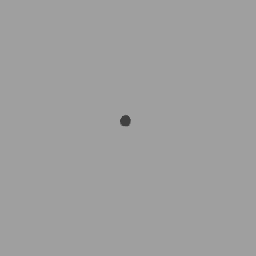

In [29]:
%%time
train_dataset = fibrosisDataset(train_df)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=0)

import imageio
from IPython.display import Image

for image in train_loader:
    print(image.shape)
    image = image.permute(0,2,3,4,1)
    print(image.shape)
    break

imageio.mimsave("/tmp/gif.gif", image[0], duration=0.0001)
Image(filename="/tmp/gif.gif", format='png')


In [30]:
del train_loader
gc.collect()

259

In [31]:
# From https://github.com/Bjarten/early-stopping-pytorch
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):

        #score = -val_loss
        score = val_loss

        if self.best_score is None:
            self.best_score = score
            #self.save_checkpoint(val_loss, model)
        elif score > self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            #self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

In [32]:
class AutoEncoder(nn.Module):
    def __init__(self, latent_features=10):
        super(AutoEncoder, self).__init__()
        # Encoder
        self.conv1 = nn.Conv3d(1, 16, 3)
        self.conv2 = nn.Conv3d(16, 32, 3)
        self.conv3 = nn.Conv3d(32, 96, 2)
        self.conv4 = nn.Conv3d(96, 1, 1)
        self.pool1 = nn.MaxPool3d(kernel_size=2, stride=2, return_indices=True)
        self.pool2 = nn.MaxPool3d(kernel_size=3, stride=3, return_indices=True)
        self.pool3 = nn.MaxPool3d(kernel_size=2, stride=2, return_indices=True)
        self.pool4 = nn.MaxPool3d(kernel_size=2, stride=2, return_indices=True)
        self.fc1 = nn.Linear(10 * 10, latent_features)
        # Decoder
        self.fc2 = nn.Linear(latent_features, 10 * 10)
        self.deconv0 = nn.ConvTranspose3d(1, 96, 1)
        self.deconv1 = nn.ConvTranspose3d(96, 32, 2)
        self.deconv2 = nn.ConvTranspose3d(32, 16, 3)
        self.deconv3 = nn.ConvTranspose3d(16, 1, 3)
        self.unpool0 = nn.MaxUnpool3d(kernel_size=2, stride=2)
        self.unpool1 = nn.MaxUnpool3d(kernel_size=2, stride=2)
        self.unpool2 = nn.MaxUnpool3d(kernel_size=3, stride=3)
        self.unpool3 = nn.MaxUnpool3d(kernel_size=2, stride=2)

    def encode(self, x, return_partials=True):
        # Encoder
        x = self.conv1(x)
        up3out_shape = x.shape
        x, i1 = self.pool1(x)

        x = self.conv2(x)
        up2out_shape = x.shape
        x, i2 = self.pool2(x)

        x = self.conv3(x)
        up1out_shape = x.shape
        x, i3 = self.pool3(x)

        x = self.conv4(x)
        up0out_shape = x.shape
        x, i4 = self.pool4(x)

        x = x.view(-1, 10 * 10)
        x = F.relu(self.fc1(x))

        if return_partials:
            return x, up3out_shape, i1, up2out_shape, i2, up1out_shape, i3, \
                   up0out_shape, i4

        else:
            return x

    def forward(self, x):
        x, up3out_shape, i1, up2out_shape, i2, \
        up1out_shape, i3, up0out_shape, i4 = self.encode(x)

        # Decoder
        x = F.relu(self.fc2(x))
        x = x.view(-1, 1, 1, 10, 10)
        x = self.unpool0(x, output_size=up0out_shape, indices=i4)
        x = self.deconv0(x)
        x = self.unpool1(x, output_size=up1out_shape, indices=i3)
        x = self.deconv1(x)
        x = self.unpool2(x, output_size=up2out_shape, indices=i2)
        x = self.deconv2(x)
        x = self.unpool3(x, output_size=up3out_shape, indices=i1)
        x = self.deconv3(x)

        return x

In [34]:
criterion = nn.MSELoss()

In [35]:
def train(epoch):
    model.train()
    train_loss = []
    PREDS = []
    optimizer.zero_grad()
    
    bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for steps, data in bar:
        
        optimizer.zero_grad()
        
        data = data.to(device).float()
        preds = model(data)
        loss = criterion(preds, data.squeeze(1))
        #loss = loss/accumulation_steps
        
        if fp16:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()
            
#         if steps % accumulation_steps == 0:
#             optimizer.step()
#             scheduler.step()
#             optimizer.zero_grad()
        
        optimizer.step()
        #scheduler.step()
        
        PREDS.append(preds.detach())
        loss_np = loss.detach().cpu().numpy()
        train_loss.append(loss_np)
        smooth_loss = sum(train_loss[-100:]) / min(len(train_loss), 100)
        bar.set_description('loss: %.5f, smth: %.5f' % (loss_np, smooth_loss))
        neptune.send_metric('lr_iter', optimizer.param_groups[0]['lr'])
    
    PREDS = torch.cat(PREDS).cpu().numpy()
    train_loss = np.mean(train_loss)
    
    neptune.send_metric('train_loss', train_loss)
    neptune.send_metric('lr', optimizer.param_groups[0]['lr'])
    
    return train_loss, PREDS

In [36]:
def valid(epoch):
    model.eval()
    valid_loss = []
    PREDS = []
    
    bar = tqdm(enumerate(valid_loader), total=len(valid_loader))
    with torch.no_grad():
        for steps, data in bar:

            data = data.to(device).float()
            preds = model(data)
            loss = criterion(preds, data.squeeze(1))

            PREDS.append(preds.detach())
            loss_np = loss.detach().cpu().numpy()
            valid_loss.append(loss_np)
    
    PREDS = torch.cat(PREDS).cpu().numpy()
    valid_loss = np.mean(valid_loss)
    scheduler.step(valid_loss)
    
    neptune.send_metric('valid_loss', valid_loss)
    
    return valid_loss, PREDS

In [37]:
def run_main(epochs, fold):
    best_loss = np.inf
    best_preds = None
    for epoch in range(1, epochs+1):
        start_time = time.time()
        torch.cuda.empty_cache()
        gc.collect()

        avg_train_loss, _ = train(epoch) 
        avg_val_loss, valid_preds = valid(epoch)
        
        elapsed = time.time() - start_time
        LOGGER.debug(f'  Epoch {epoch} - avg_train_loss: {avg_train_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        if avg_val_loss<best_loss:
            torch.save(model.state_dict(), f'model_fold_{fold}.pt')
            best_loss=avg_val_loss
        checkpoint = {
            'epoch': epoch,
            'lr': optimizer.param_groups[0]['lr'],
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            }
        torch.save(checkpoint, 'checkpoint.pt')
        
        early_stopping(avg_val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
    return valid_score, valid_preds 

In [38]:
valid_score = []
valid_preds = []
for fold in range(CFG.n_fold):
    print(f'Training fold {fold}')
    
    model = model = AutoEncoder().to(device)    
    optimizer = torch.optim.Adam(model.parameters(), lr=CFG.lr)
    scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.7, patience=5, verbose=True, eps=1e-6)
    
    train_idx = np.where((train_df['fold'] != fold))[0]
    valid_idx = np.where((train_df['fold'] == fold))[0]

    train_data  = train_df.loc[train_idx]
    valid_data = train_df.loc[valid_idx] 

    train_dataset = fibrosisDataset(train_data)
    train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)

    valid_dataset = fibrosisDataset(valid_data)
    valid_loader = DataLoader(valid_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    
    early_stopping = EarlyStopping(patience=10, verbose=False)

    score, preds = run_main(CFG.epochs, fold)
    valid_preds.append(preds)
    del train_dataset, train_loader, valid_dataset, valid_loader, model
    gc.collect()

Training fold 0


100%|██████████| 4/4 [01:46<00:00, 26.67s/it]
2020-08-21 04:09:06,787 DEBUG   Epoch 1 - avg_train_loss: 0.3737  avg_val_loss: 0.1948  time: 329s
100%|██████████| 4/4 [01:45<00:00, 26.28s/it]
2020-08-21 04:14:38,634 DEBUG   Epoch 2 - avg_train_loss: 0.1576  avg_val_loss: 0.1180  time: 332s
100%|██████████| 4/4 [01:46<00:00, 26.71s/it]
2020-08-21 04:20:15,205 DEBUG   Epoch 3 - avg_train_loss: 0.0864  avg_val_loss: 0.0631  time: 337s
100%|██████████| 4/4 [01:48<00:00, 27.20s/it]
2020-08-21 04:25:49,739 DEBUG   Epoch 4 - avg_train_loss: 0.0539  avg_val_loss: 0.0464  time: 335s
100%|██████████| 4/4 [01:49<00:00, 27.40s/it]
2020-08-21 04:31:38,033 DEBUG   Epoch 5 - avg_train_loss: 0.0429  avg_val_loss: 0.0387  time: 348s
100%|██████████| 4/4 [01:46<00:00, 26.65s/it]
2020-08-21 04:37:16,496 DEBUG   Epoch 6 - avg_train_loss: 0.0409  avg_val_loss: 0.0364  time: 338s
100%|██████████| 4/4 [01:49<00:00, 27.43s/it]
2020-08-21 04:42:52,010 DEBUG   Epoch 7 - avg_train_loss: 0.0385  avg_val_loss: 0.03

Training fold 1


100%|██████████| 4/4 [01:55<00:00, 28.84s/it]
2020-08-21 06:31:28,263 DEBUG   Epoch 1 - avg_train_loss: 0.1908  avg_val_loss: 0.1161  time: 342s
100%|██████████| 4/4 [01:56<00:00, 29.08s/it]
2020-08-21 06:37:08,577 DEBUG   Epoch 2 - avg_train_loss: 0.0840  avg_val_loss: 0.0607  time: 340s
100%|██████████| 4/4 [01:55<00:00, 28.82s/it]
2020-08-21 06:42:48,015 DEBUG   Epoch 3 - avg_train_loss: 0.0477  avg_val_loss: 0.0384  time: 339s
100%|██████████| 4/4 [01:54<00:00, 28.60s/it]
2020-08-21 06:48:26,329 DEBUG   Epoch 4 - avg_train_loss: 0.0355  avg_val_loss: 0.0291  time: 338s
100%|██████████| 4/4 [01:55<00:00, 28.84s/it]
2020-08-21 06:54:03,458 DEBUG   Epoch 5 - avg_train_loss: 0.0310  avg_val_loss: 0.0278  time: 337s
100%|██████████| 4/4 [01:54<00:00, 28.73s/it]
2020-08-21 06:59:46,842 DEBUG   Epoch 6 - avg_train_loss: 0.0301  avg_val_loss: 0.0272  time: 343s
100%|██████████| 4/4 [01:54<00:00, 28.73s/it]
2020-08-21 07:05:27,490 DEBUG   Epoch 7 - avg_train_loss: 0.0289  avg_val_loss: 0.02

EarlyStopping counter: 1 out of 10


100%|██████████| 4/4 [01:57<00:00, 29.48s/it]
2020-08-21 08:42:31,571 DEBUG   Epoch 24 - avg_train_loss: 0.0253  avg_val_loss: 0.0237  time: 344s


EarlyStopping counter: 2 out of 10


100%|██████████| 4/4 [01:58<00:00, 29.62s/it]
2020-08-21 08:48:17,490 DEBUG   Epoch 25 - avg_train_loss: 0.0256  avg_val_loss: 0.0232  time: 346s


EarlyStopping counter: 3 out of 10
Training fold 2


100%|██████████| 4/4 [02:01<00:00, 30.36s/it]
2020-08-21 08:54:00,264 DEBUG   Epoch 1 - avg_train_loss: 0.4927  avg_val_loss: 0.2625  time: 343s
100%|██████████| 4/4 [02:01<00:00, 30.32s/it]
2020-08-21 08:59:44,316 DEBUG   Epoch 2 - avg_train_loss: 0.2151  avg_val_loss: 0.1562  time: 344s
100%|██████████| 4/4 [02:01<00:00, 30.29s/it]
2020-08-21 09:05:34,263 DEBUG   Epoch 3 - avg_train_loss: 0.1272  avg_val_loss: 0.0920  time: 350s
100%|██████████| 4/4 [02:05<00:00, 31.35s/it]
2020-08-21 09:11:29,911 DEBUG   Epoch 4 - avg_train_loss: 0.0730  avg_val_loss: 0.0557  time: 356s
100%|██████████| 4/4 [02:02<00:00, 30.71s/it]
2020-08-21 09:17:20,753 DEBUG   Epoch 5 - avg_train_loss: 0.0502  avg_val_loss: 0.0479  time: 351s
100%|██████████| 4/4 [02:03<00:00, 30.81s/it]
2020-08-21 09:23:18,641 DEBUG   Epoch 6 - avg_train_loss: 0.0436  avg_val_loss: 0.0423  time: 358s
100%|██████████| 4/4 [02:00<00:00, 30.22s/it]
2020-08-21 09:29:01,144 DEBUG   Epoch 7 - avg_train_loss: 0.0399  avg_val_loss: 0.04

In [39]:
valid_preds[0].shape
preds1 = np.asarray(valid_preds)
preds1.shape

(3,)

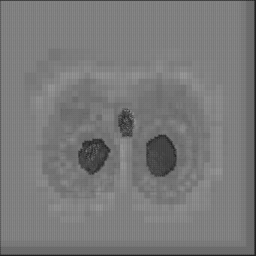

In [40]:
import imageio
from IPython.display import Image

imageio.mimsave("/tmp/gif.gif", preds1[0][15][0], duration=0.0001)
Image(filename="/tmp/gif.gif", format='png') 

In [41]:
neptune.stop()